<a href="https://colab.research.google.com/github/PADGE383/Padgett-Lensing/blob/main/Grid_Search_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports and Installs

In [ ]:
!pip install lenstronomy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.3 MB/s eta 0:00:00
  Created wheel for lenstronomy: filename=lenstronomy-1.11.5-py3-none-any.whl size=1139061 sha256=c88fb4bd8f2a7208936426a09b7ff3f42d9ebef4291f9474224f65c0ab93e2ee
  Stored in directory: /root/.cache/pip/wheels/78/dd/d9/bbdd80cec79b57ec559b7183476b0e8802a2c029e312d05b0f
  Created wheel for schwimmbad: filename=schwimmbad-0.3.2-py3-none-any.whl size=15729 sha256=4d65477d9f41af91c379b8d88c04267e5b61947ea38a97932de0bd9aa5dce7f9
  Stored in directory: /root/.cache/pip/wheels/4a/ea/3e/b79646d96eaea54

In [ ]:
# some standard python imports #
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
import ast
from tqdm import tqdm
import pandas as pd
import csv
import operator

%matplotlib inline

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Plots import lens_plot
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.param_util as param_util
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions


/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


Functions

In [ ]:
def sorter(ra_list,dec_list):
  r_list=[]
  theta_list=[]

  for i in range(4):
      tempra=ra_list[i]
      tempdec=dec_list[i]
      tempr, temptheta= cart2pol(tempra,tempdec)
      r_list.append(tempr)
      theta_list.append(temptheta)


  idx=np.argsort(theta_list)
  adex=idx[0]
  bdex=idx[1]
  cdex=idx[2]
  ddex=idx[3]

  return adex, bdex, cdex, ddex, idx

In [ ]:
def gridsearchV2(parameters,resolution,target_ratio,brek):
    # graphing and analysis constants #
    name=parameters[0]                          #Name of system
    rep_rad=float(parameters[1])

    lens_ra=float(parameters[7])                #Lens/Deflector RA
    lens_dec=float(parameters[8])               #Lens/Deflector DEC

    delta_ra=ast.literal_eval(parameters[9])    #Image RA Position List Defined as [A,B,C,D,lra,sra]
    delta_dec=ast.literal_eval(parameters[10])  #Image DEC Position List Defined as[A,B,C,D,ldec,sdec]

    rep_theta_ra=np.array(delta_ra[:4])
    rep_theta_dec=np.array(delta_dec[:4])

    rep_theta_r=[]
    rep_theta_theta=[]

    for i in range(4):
        tempra=rep_theta_ra[i]
        tempdec=rep_theta_dec[i]
        tempr, temptheta= cart2pol(tempra,tempdec)
        rep_theta_r.append(tempr)
        rep_theta_theta.append(temptheta)


    idx=np.argsort(rep_theta_theta)
    rep_theta_theta=np.array(rep_theta_theta)
    rep_sort_theta=rep_theta_theta[idx]
    rep_sort_ra=rep_theta_ra[idx]
    rep_sort_dec=rep_theta_dec[idx]


    rep_beta_ra=delta_ra[5]
    rep_beta_dec=delta_dec[5]

    # model maker #
    act_solver, act_kwargs_lens, act_deltapix, act_numpix, ra_caustic_min, ra_caustic_max, dec_caustic_min, dec_caustic_max, pth= modelmakerV2(parameters)

    # inital grid search setting#
    min_ratio=float("nan")
    tar_ratio=target_ratio
    res=resolution-25
    count=0
    central_ra=lens_ra
    central_dec=lens_dec

    ra_min=ra_caustic_min
    ra_max=ra_caustic_max
    dec_min=dec_caustic_min
    dec_max=dec_caustic_max

    # grid search #

    while tar_ratio<=min_ratio or np.isnan(min_ratio)==True:
      res=res+25
      # gridmaker #
      tli = []
      caustic_ra = []
      caustic_dec = []

      for i in np.linspace(ra_min,ra_max,res):
          for j in np.linspace(dec_min,dec_max,res):
              tli.append(pth.contains_point((i,j)))
              caustic_ra.append(i)
              caustic_dec.append(j)
      tli = np.array(tli)
      caustic_ra = np.array(caustic_ra)
      caustic_dec = np.array(caustic_dec)
      sra_ar=caustic_ra[tli]
      sdec_ar= caustic_dec[tli]
      scord_list= []
      for i in range(len(sra_ar)):
        temp_sra=sra_ar[i]
        temp_sdec=sdec_ar[i]
        temp_cord=[temp_sra,temp_sdec]
        scord_list.append(temp_cord)
      scord=np.array(scord_list)

      # Grid Search #
      deltaar=[]
      sraar=[]
      sdecar=[]
      for sra,sdec in tqdm(scord):

        theta_ra, theta_dec= imgpos(act_solver, sra, sdec, act_kwargs_lens, act_deltapix, act_numpix)

        if len(theta_ra)<4:
            continue
        else:
            theta_ra=np.array(theta_ra)
            theta_dec=np.array(theta_dec)
            calc_r=[]
            calc_theta=[]

            for k in range(4):
                tempcra=theta_ra[k]
                tempcdec=theta_dec[k]
                tempcr, tempctheta=cart2pol(tempcra,tempcdec)

                calc_r.append(tempcr)
                calc_theta.append(tempctheta)

            idx=np.argsort(calc_theta)
            sort_ra=theta_ra[idx]
            sort_dec=theta_dec[idx]



            delta_ra=[]
            delta_dec=[]
            for ind in range(4):
                delta_pos_ra= np.abs(sort_ra[ind]-rep_sort_ra[ind])
                delta_pos_dec= np.abs(sort_dec[ind]-rep_sort_dec[ind])

                delta_ra.append(delta_pos_ra)
                delta_dec.append(delta_pos_dec)

            dra=np.array(delta_ra)
            ddec=np.array(delta_dec)

            delta=np.sqrt(np.sum((dra**2)+(ddec**2)))

            deltaar.append(delta)
            sraar.append(sra)
            sdecar.append(sdec)

      min_delta=min(deltaar)
      min_ratio=min_delta/rep_rad
      index_min=deltaar.index(min_delta)
      central_ra=sraar[index_min]
      central_dec=sdecar[index_min]

      interval_ra=np.abs(ra_max-ra_min)
      interval_dec=np.abs(dec_max-dec_min)

      ra_min=central_ra-(interval_ra/4)
      ra_max=central_ra+(interval_ra/4)
      dec_min=central_dec-(interval_dec/4)
      dec_max=central_dec+(interval_dec/4)

      count+=1
      if count==brek:
          break

    delta_log=np.log10(deltaar)

    return name, rep_beta_ra, rep_beta_dec, central_ra, central_dec, delta_log, sraar, sdecar

In [ ]:
def modelmakerV2(par):
    # lens parameters #
    theta_E=float(par[1])                #Einstien Radius (arcsec)
    gamma=float(par[2])                  #Gamma
    q=float(par[3])                      #Elipticity Intensity
    phi=float(par[4])                    #Eliptcity Direction (Deg N of E)
    gammaext=float(par[5])               #External Shear Gamma
    phiext=float(par[6])                 #External Shear Direction (Deg N of E)
    lra=float(par[7])                    #Lens/Deflector RA
    ldec=float(par[8])                   #Lens/Deflector DEC
    delta_ra=ast.literal_eval(par[9])    #Image RA Position List Defined as [A,B,C,D,lra,sra,0]
    delta_dec=ast.literal_eval(par[10])  #Image DEC Position List Defined as[A,B,C,D,ldec,sdec,0]
    zl=float(par[13])                    #Lens/Deflector Redshift
    zs=float(par[14])                    #Source Redshift

    # equation for param #
    e1, e2 = param_util.phi_q2_ellipticity(np.deg2rad(phi),q)
    gamma2=gammaext*(np.sin(2*np.deg2rad(phiext)))
    gamma1=gammaext*(np.cos(2*np.deg2rad(phiext)))

    # define search area parameters #
    res=5000
    maxv=np.max(np.abs(delta_ra+delta_dec))
    bord=maxv*1
    deltapix=float(np.sqrt((2*(bord+maxv)/res)))
    numpix=int(res*deltapix)

    # lens and model list #
    kwargs_spep = {'theta_E': theta_E,'gamma':gamma, 'e1': e1, 'e2': e2, 'center_x': lra, 'center_y': ldec}
    kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}
    kwargs_lens=[kwargs_spep,kwargs_shear]
    kwargs_caustic_num = {'compute_window': numpix,'grid_scale': deltapix,'center_x': 0,'center_y': 0}

    lens_model_list= ['EPL','SHEAR']

    # lens model and solver #
    lensModel=LensModel(lens_model_list=lens_model_list,z_lens=zl,z_source=zs)
    lensModelExtensions = LensModelExtensions(lensModel=lensModel)
    solver=LensEquationSolver(lensModel)

    # caustic path #
    (ra_crit_list,dec_crit_list,ra_caustic_list,dec_caustic_list,) = lensModelExtensions.critical_curve_caustics(kwargs_lens,compute_window=6,grid_scale=0.01,center_x=lra,center_y=ldec)
    arr = np.vstack((ra_caustic_list[0],dec_caustic_list[0])).swapaxes(0,1)
    pth = mplPath.Path(arr)

    ra_caustic_min=np.min(ra_caustic_list[0])
    ra_caustic_max=np.max(ra_caustic_list[0])
    dec_caustic_min=np.min(dec_caustic_list[0])
    dec_caustic_max=np.max(dec_caustic_list[0])

    return solver, kwargs_lens, deltapix, numpix, ra_caustic_min, ra_caustic_max, dec_caustic_min, dec_caustic_max, pth

In [ ]:
#New Function Maker
def systemmakerV2(par,g_ra,g_dec):
    # define parameters

    name=par[0]                          #Name of system
    theta_E=float(par[1])                #Einstien Radius (arcsec)
    gamma=float(par[2])                  #Gamma
    q=float(par[3])                      #Elipticity Intensity
    phi=float(par[4])                    #Eliptcity Direction (Deg N of E)
    gammaext=float(par[5])               #External Shear Gamma
    phiext=float(par[6])                 #External Shear Direction (Deg N of E)
    lra=float(par[7])                    #Lens/Deflector RA
    ldec=float(par[8])                   #Lens/Deflector DEC
    delta_ra=ast.literal_eval(par[9])    #Image RA Position List Defined as [A,B,C,D,lra,sra,0]
    delta_dec=ast.literal_eval(par[10])  #Image DEC Position List Defined as[A,B,C,D,ldec,sdec,0]
    sra=g_ra
    sdec=g_dec
    zl=float(par[13])                    #Lens/Deflector Redshift
    zs=float(par[14])                    #Source Redshift


    label=["A","B","C","D","Main Defelctor","Unlensed Position"]

    # equation for param
    e1, e2 = param_util.phi_q2_ellipticity(np.deg2rad(phi),q)
    gamma2=gammaext*(np.sin(2*np.deg2rad(phiext)))
    gamma1=gammaext*(np.cos(2*np.deg2rad(phiext)))
    totgamma=np.sqrt(gamma1**2+gamma2**2)

    # define search area parameters #
    res=7000
    maxv=np.max(np.abs(delta_ra+delta_dec))
    bord=maxv*1
    deltapix=float(np.sqrt((2*(bord+maxv)/res)))
    numpix=int(res*deltapix)

    # specify the choice of lens models #
    lens_model_list = ['EPL','SHEAR']

    # setup lens model class with the list of lens models #
    lensModel = LensModel(lens_model_list=lens_model_list,z_lens=zl,z_source=zs)
    #lensModelExtensions = LensModelExtensions(lensModel=lensModel)

    # define parameter values of lens models #
    kwargs_spep = {'theta_E': theta_E,'gamma':gamma, 'e1': e1, 'e2': e2, 'center_x': lra, 'center_y': ldec}
    kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}
    kwargs_lens = [kwargs_spep,kwargs_shear]
    kwargs_caustic_num = {'compute_window': numpix,'grid_scale': deltapix,'center_x': 0,'center_y': 0}

    # source plane coordinate #
    beta_ra=sra
    beta_dec=sdec

    # specifiy the lens model class to deal with #
    solver = LensEquationSolver(lensModel)

    # solve for image positions provided a lens model and the source position #
    theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens, min_distance=deltapix, search_window=deltapix*numpix)

    # Magnification #
    mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

    # arrival time relative to a straight path through (0,0) #
    dt = lensModel.arrival_time(theta_ra, theta_dec, kwargs_lens)

    return numpix, deltapix, lensModel, kwargs_lens, beta_ra, beta_dec, label, name, delta_ra, delta_dec, theta_ra, theta_dec, mag, dt

In [ ]:
def gridsearch(parameters,resolution,target_ratio):
    # graphing and analysis constants #
    name=parameters[0]                          #Name of system
    rep_rad=float(parameters[1])

    lens_ra=float(parameters[7])                #Lens/Deflector RA
    lens_dec=float(parameters[8])               #Lens/Deflector DEC

    delta_ra=ast.literal_eval(parameters[9])    #Image RA Position List Defined as [A,B,C,D,lra,sra]
    delta_dec=ast.literal_eval(parameters[10])  #Image DEC Position List Defined as[A,B,C,D,ldec,sdec]

    rep_theta_ra=np.array(delta_ra[:4])
    rep_theta_dec=np.array(delta_dec[:4])

    rep_theta_r=[]
    rep_theta_theta=[]

    for i in range(4):
        tempra=rep_theta_ra[i]
        tempdec=rep_theta_dec[i]
        tempr, temptheta= cart2pol(tempra,tempdec)
        rep_theta_r.append(tempr)
        rep_theta_theta.append(temptheta)


    idx=np.argsort(rep_theta_theta)
    rep_theta_theta=np.array(rep_theta_theta)
    rep_sort_theta=rep_theta_theta[idx]
    rep_sort_ra=rep_theta_ra[idx]
    rep_sort_dec=rep_theta_dec[idx]


    rep_beta_ra=delta_ra[5]
    rep_beta_dec=delta_dec[5]

    # model maker #
    act_solver, act_kwargs_lens, act_deltapix, act_numpix, act_area= modelmaker(parameters)

    # starting parameters #
    central_ra=lens_ra
    central_dec=lens_dec
    start_area=act_area*9

    # scale
    resolution=resolution
    count=0
    # USE ROUNDS TO GO UNDER CERTAIN DELTA 0.1arcsec#

    # grid search #
    min_ratio=float("nan")
    tar_ratio=target_ratio

    while tar_ratio<=min_ratio or np.isnan(min_ratio)==True:
        start_area=start_area/3
        grid_lenth=np.sqrt(start_area)
        grid_width=np.sqrt(start_area)

        lenth_step=grid_lenth/resolution
        width_step=grid_width/resolution

        start_ra=central_ra+(grid_lenth/2)
        start_dec=central_dec+(grid_width/2)

        deltaar=[]
        sraar=[]
        sdecar=[]

        for i in tqdm(range(resolution)):
            ddec=i*width_step
            sdec=(start_dec-ddec)
            for j in range(resolution):
                dra=j*lenth_step
                sra=(start_ra-dra)

                theta_ra, theta_dec= imgpos(act_solver, sra, sdec, act_kwargs_lens, act_deltapix, act_numpix)

                if len(theta_ra)<4:
                    continue
                else:
                    theta_ra=np.array(theta_ra)
                    theta_dec=np.array(theta_dec)
                    calc_r=[]
                    calc_theta=[]

                    for k in range(4):
                        tempcra=theta_ra[k]
                        tempcdec=theta_dec[k]
                        tempcr, tempctheta=cart2pol(tempcra,tempcdec)

                        calc_r.append(tempcr)
                        calc_theta.append(tempctheta)

                    idx=np.argsort(calc_theta)
                    sort_ra=theta_ra[idx]
                    sort_dec=theta_dec[idx]



                    delta_ra=[]
                    delta_dec=[]
                    for ind in range(4):
                        delta_pos_ra= np.abs(sort_ra[ind]-rep_sort_ra[ind])
                        delta_pos_dec= np.abs(sort_dec[ind]-rep_sort_dec[ind])

                        delta_ra.append(delta_pos_ra)
                        delta_dec.append(delta_pos_dec)

                    dra=np.array(delta_ra)
                    ddec=np.array(delta_dec)

                    delta=np.sqrt(np.sum((dra**2)+(ddec**2)))

                    deltaar.append(delta)
                    sraar.append(sra)
                    sdecar.append(sdec)

        min_delta=min(deltaar)
        min_ratio=min_delta/rep_rad
        index_min=deltaar.index(min_delta)
        central_ra=sraar[index_min]
        central_dec=sdecar[index_min]
        count+=1
        if count==1:
            break
        print(count)

    delta_log=np.log10(deltaar)

    return name, rep_beta_ra, rep_beta_dec, central_ra, central_dec, delta_log, sraar, sdecar

In [ ]:
#New Function Maker
def systemmaker(par,g_ra,g_dec):
    # define parameters

    name=par[0]                          #Name of system
    theta_E=float(par[1])                #Einstien Radius (arcsec)
    gamma=float(par[2])                  #Gamma
    q=float(par[3])                      #Elipticity Intensity
    phi=float(par[4])                    #Eliptcity Direction (Deg N of E)
    gammaext=float(par[5])               #External Shear Gamma
    phiext=float(par[6])                 #External Shear Direction (Deg N of E)
    lra=float(par[7])                    #Lens/Deflector RA
    ldec=float(par[8])                   #Lens/Deflector DEC
    delta_ra=ast.literal_eval(par[9])    #Image RA Position List Defined as [A,B,C,D,lra,sra,0]
    delta_dec=ast.literal_eval(par[10])  #Image DEC Position List Defined as[A,B,C,D,ldec,sdec,0]
    sra=g_ra
    sdec=g_dec
    zl=float(par[13])                    #Lens/Deflector Redshift
    zs=float(par[14])                    #Source Redshift


    label=["A","B","C","D","Main Defelctor","Unlensed Position"]

    # equation for param
    e1, e2 = param_util.phi_q2_ellipticity(np.deg2rad(phi),q)
    gamma2=gammaext*(np.sin(2*np.deg2rad(phiext)))
    gamma1=gammaext*(np.cos(2*np.deg2rad(phiext)))
    totgamma=np.sqrt(gamma1**2+gamma2**2)

    # define search area parameters #
    res=7000
    maxv=np.max(np.abs(delta_ra+delta_dec))
    bord=maxv*1
    deltapix=float(np.sqrt((2*(bord+maxv)/res)))
    numpix=int(res*deltapix)

    # specify the choice of lens models #
    lens_model_list = ['EPL','SHEAR']

    # setup lens model class with the list of lens models #
    lensModel = LensModel(lens_model_list=lens_model_list,z_lens=zl,z_source=zs)
    #lensModelExtensions = LensModelExtensions(lensModel=lensModel)

    # define parameter values of lens models #
    kwargs_spep = {'theta_E': theta_E,'gamma':gamma, 'e1': e1, 'e2': e2, 'center_x': lra, 'center_y': ldec}
    kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}
    kwargs_lens = [kwargs_spep,kwargs_shear]
    kwargs_caustic_num = {'compute_window': numpix,'grid_scale': deltapix,'center_x': 0,'center_y': 0}

    # source plane coordinate #
    #beta_ra, beta_dec = sra,sdec
    beta_ra=sra
    beta_dec=sdec

    # Fermat potential #
    #fermat_pot = lensModel.fermat_potential(x_image=theta_ra, y_image=theta_dec, x_source=beta_ra, y_source=beta_dec, kwargs_lens=kwargs_lens)

    # specifiy the lens model class to deal with #
    #solver = LensEquationSolver(lensModel)

    # solve for image positions provided a lens model and the source position #
    #theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens, min_distance=deltapix, search_window=deltapix*numpix)

    # Magnification #
    #mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

    # arrival time relative to a straight path through (0,0) #
    #dt = lensModel.arrival_time(theta_ra, theta_dec, kwargs_lens)

    # caustic area #
    #area = lensModelExtensions.caustic_area(kwargs_lens=kwargs_lens, kwargs_caustic_num=kwargs_caustic_num, index_vertices=0)

    # Trace back of source positon #
    #pap_ra=[delta_ra[:4]]
    #pap_dec=[delta_dec[:4]]
    #esra, esdec = lensModel.ray_shooting(theta_ra, theta_dec, kwargs_lens)

    return numpix, deltapix, lensModel, kwargs_lens, beta_ra, beta_dec, label, name, delta_ra, delta_dec

In [ ]:
def modelmaker(par):

    name=par[0]                          #Name of system
    delta_ra=ast.literal_eval(par[9])    #Image RA Position List Defined as [A,B,C,D,lra,sra,0]
    delta_dec=ast.literal_eval(par[10])  #Image DEC Position List Defined as[A,B,C,D,ldec,sdec,0]
    sra=float(par[11])                   #Unlensed Source RA
    sdec=float(par[12])                  #Unlensed Source DEC

    # lens parameters #
    theta_E=float(par[1])                #Einstien Radius (arcsec)
    gamma=float(par[2])                  #Gamma
    q=float(par[3])                      #Elipticity Intensity
    phi=float(par[4])                    #Eliptcity Direction (Deg N of E)
    gammaext=float(par[5])               #External Shear Gamma
    phiext=float(par[6])                 #External Shear Direction (Deg N of E)
    lra=float(par[7])                    #Lens/Deflector RA
    ldec=float(par[8])                   #Lens/Deflector DEC
    zl=float(par[13])                    #Lens/Deflector Redshift
    zs=float(par[14])                    #Source Redshift

    # equation for param #
    e1, e2 = param_util.phi_q2_ellipticity(np.deg2rad(phi),q)
    gamma2=gammaext*(np.sin(2*np.deg2rad(phiext)))
    gamma1=gammaext*(np.cos(2*np.deg2rad(phiext)))

    # define search area parameters #
    res=5000
    maxv=np.max(np.abs(delta_ra+delta_dec))
    bord=maxv*1
    deltapix=float(np.sqrt((2*(bord+maxv)/res)))
    numpix=int(res*deltapix)

    # lens and model list #
    kwargs_spep = {'theta_E': theta_E,'gamma':gamma, 'e1': e1, 'e2': e2, 'center_x': lra, 'center_y': ldec}
    kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}
    kwargs_lens=[kwargs_spep,kwargs_shear]
    kwargs_caustic_num = {'compute_window': numpix,'grid_scale': deltapix,'center_x': 0,'center_y': 0}

    lens_model_list= ['EPL','SHEAR']

    # lens model and solver #
    lensModel=LensModel(lens_model_list=lens_model_list,z_lens=zl,z_source=zs)
    lensModelExtensions = LensModelExtensions(lensModel=lensModel)
    solver=LensEquationSolver(lensModel)

    # area #
    area = lensModelExtensions.caustic_area(kwargs_lens=kwargs_lens, kwargs_caustic_num=kwargs_caustic_num, index_vertices=0)

    return solver, kwargs_lens, deltapix, numpix, area

In [ ]:
def imgpos(solver,beta_ra, beta_dec, kwargs_lens, deltapix, numpix):

    theta_ra,theta_dec=solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens, min_distance=deltapix, search_window=deltapix*numpix)

    return theta_ra,theta_dec

In [ ]:
def cart2pol(x,y):
    r= np.sqrt((x**2)+(y**2))
    theta= np.arctan2(y,x)

    return r, theta

Paper Data (data)

In [ ]:
# data #
datafile="/content/Collected Data 8.csv"
data=np.loadtxt(datafile, delimiter=';',dtype=str)

Grid Search of All Systems (Long runtime)

In [ ]:
#All Systems
fname="Grid Search V4.pdf"
#Plot and gather data
grid_ra=[]
grid_dec=[]
grid_delta=[]
fig =plt.figure(figsize=(40, 40))
for i in range(len(data)):
    ax=fig.add_subplot(6,5,i+1)
    temp_system=data[i]
    res=50
    target=.03
    brk=4
    name, rep_beta_ra, rep_beta_dec, central_ra, central_dec, delta_log,sraar,sdecar=gridsearchV2(temp_system,res,target,brk)
    delta_reg=10**(delta_log)
    temp_min_delta=min(delta_reg)
    grid_ra.append(central_ra)
    grid_dec.append(central_dec)
    grid_delta.append(temp_min_delta)

    ax.scatter(rep_beta_ra, rep_beta_dec,color='black',marker='x')
    sc=ax.scatter(sraar,sdecar,c=delta_log,cmap='rainbow_r',s=100)
    ax.scatter(central_ra,central_dec,fc='none',ec='black',s=400)

    plt.colorbar(sc,label='Average Differnce in Image Position (arcseconds)',ax=ax)
    ax.title.set_text(name)
    txt1="("+str(rep_beta_ra)+","+str(rep_beta_dec)+")"
    txt2="("+str("%.3f" % central_ra)+","+str("%.3f" % central_dec)+")"
    ax.annotate(txt1,(rep_beta_ra, rep_beta_dec))
    ax.annotate(txt2,(central_ra,central_dec))
    ax.grid()

plt.tight_layout()
plt.savefig(fname,format='pdf')
plt.close()

100%|██████████| 796/796 [00:32<00:00, 24.59it/s]


In [ ]:
# Gathering bets estimated source positions and min delta #
grid_ra=[]
grid_dec=[]
grid_delta=[]
for i in tqdm(range(len(data))):
    temp_system=data[i]
    res=10
    target=.1
    name, rep_beta_ra, rep_beta_dec, central_ra, central_dec, delta_log,sraar,sdecar=gridsearch(temp_system,res,target)
    delta_reg=10**(delta_log)
    temp_min_delta=min(delta_reg)
    grid_ra.append(central_ra)
    grid_dec.append(central_dec)
    grid_delta.append(temp_min_delta)

100%|██████████| 30/30 [32:54<00:00, 65.82s/it]


In [ ]:
grid_data=[]
for i in tqdm(range(len(grid_ra))):
  temp_ra=grid_ra[i]
  temp_dec=grid_dec[i]
  temp_delta=grid_delta[i]
  temp_line=[temp_ra,temp_dec,temp_delta]
  grid_data.append(temp_line)

100%|██████████| 23/23 [00:00<00:00, 7720.61it/s]


In [ ]:
filename="Grid Data V3.csv"

# Open the CSV file in write mode and specify newline='' to prevent extra newline characters
with open(filename, mode='w', newline='') as file:
    # Create a CSV writer object
    csv_writer = csv.writer(file,delimiter=";")

    # Write the data to the CSV file
    csv_writer.writerows(grid_data)

print(f"CSV file '{filename}' has been created successfully.")

CSV file 'Grid Data V3.csv' has been created successfully.


Grid data

In [ ]:
griddatafile="/content/Grid Data V6.csv"
grid_ra=np.loadtxt(griddatafile, delimiter=',', dtype=float, usecols=0)
grid_dec=np.loadtxt(griddatafile, delimiter=',', dtype=float, usecols=1)
grid_delta=np.loadtxt(griddatafile, delimiter=',', dtype=float, usecols=2)

Creates model of All Systems (Long runtime)

In [ ]:
#All Grid Search Systems
fname="Grid Systems V6.pdf"
#Plot and gather data
fig =plt.figure(figsize=(40, 40))
for i in tqdm(range(len(data))):
    ax=fig.add_subplot(6,5,i+1)
    numpix, deltapix, lensModel, kwargs_lens, beta_ra, beta_dec, label, name, delta_ra, delta_dec=systemmaker(data[i],grid_ra[i],grid_dec[i])
    lens_plot.lens_model_plot(ax, numPix=numpix, deltaPix=deltapix, lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True, with_caustics=True, fast_caustic=False, coord_inverse=True)
    ax.scatter(delta_ra,delta_dec,color="red")
#    for q, txt in enumerate(label):
#        ax.annotate(txt, (delta_ra[q], delta_dec[q]),color='white')
    ax.scatter(beta_ra, beta_dec,color='red')
    ax.title.set_text(name)
    ax.grid()

plt.tight_layout()
plt.savefig(fname,format='pdf')
plt.close()

100%|██████████| 23/23 [03:30<00:00,  9.14s/it]


Time Delay Calculations (requires paper data and grid data)


In [ ]:
mod_timedel=[]
rep_timedel=[]
delta_timedel_ar=[]

mod_impos_ar=[]
rep_impos_ar=[]

mod_mag_ar=[]
rep_mag_ar=[]
for i in tqdm(range(len(data))):
  temp_system=data[i]

  # image positions #
  delta_ra=ast.literal_eval(temp_system[9])    #Image RA Position List Defined as [A,B,C,D,lra,sra]
  delta_dec=ast.literal_eval(temp_system[10])  #Image DEC Position List Defined as[A,B,C,D,ldec,sdec]

  rep_im_ra=np.array(delta_ra[:4])
  rep_im_dec=np.array(delta_dec[:4])

  rep_adex, rep_bdex, rep_cdex, rep_ddex, rep_idx = sorter(rep_im_ra,rep_im_dec)


  numpix, deltapix, lensModel, kwargs_lens, beta_ra, beta_dec, label, name, delta_ra, delta_dec, mod_im_ra, mod_im_dec, mod_mag, mod_dt=systemmakerV2(temp_system,grid_ra[i],grid_dec[i])

  mod_adex, mod_bdex, mod_cdex, mod_ddex, mod_idx = sorter(mod_im_ra,mod_im_dec)

  mod_im_ra_ar=np.array(mod_im_ra)
  sort_im_ra=mod_im_ra_ar[mod_idx]
  mod_im_Ara=sort_im_ra[rep_adex]
  mod_im_Bra=sort_im_ra[rep_bdex]
  mod_im_Cra=sort_im_ra[rep_cdex]
  mod_im_Dra=sort_im_ra[rep_ddex]

  mod_im_dec_ar=np.array(mod_im_dec)
  sort_im_dec=mod_im_dec_ar[mod_idx]
  mod_im_Adec=sort_im_dec[rep_adex]
  mod_im_Bdec=sort_im_dec[rep_bdex]
  mod_im_Cdec=sort_im_dec[rep_cdex]
  mod_im_Ddec=sort_im_dec[rep_ddex]

  mod_impos_ar.append([[mod_im_Ara,mod_im_Adec],[mod_im_Bra,mod_im_Bdec],[mod_im_Cra,mod_im_Cdec],[mod_im_Dra,mod_im_Ddec]])
  rep_impos_ar.append([[rep_im_ra[0],rep_im_dec[0]],[rep_im_ra[2],rep_im_dec[1]],[rep_im_ra[2],rep_im_dec[2]],[rep_im_ra[3],rep_im_dec[3]]])

  # time delay #
  mod_dt_ar=np.array(mod_dt)
  sort_mod_dt_ar=mod_dt_ar[mod_idx]

  Adt=sort_mod_dt_ar[rep_adex]
  Bdt=sort_mod_dt_ar[rep_bdex]
  Cdt=sort_mod_dt_ar[rep_cdex]
  Ddt=sort_mod_dt_ar[rep_ddex]

  mod_AB=Adt-Bdt
  mod_AC=Adt-Cdt
  mod_AD=Adt-Ddt
  mod_timedel.append([mod_AB,mod_AC,mod_AD])
  mean_mod_timedel=np.mean([mod_AB,mod_AC,mod_AD])

  rep_AB=float(temp_system[15])
  rep_AC=float(temp_system[16])
  rep_AD=float(temp_system[17])
  rep_timedel.append([rep_AB,rep_AC,rep_AD])

  delta_AB=np.abs(mod_AB-rep_AB)
  delta_AC=np.abs(mod_AC-rep_AC)
  delta_AD=np.abs(mod_AD-rep_AD)
  delta_timedel=np.sqrt((delta_AB**2)+(delta_AC**2)+(delta_AD**2))
  delta_per_timedel=np.abs(delta_timedel/mean_mod_timedel)
  delta_timedel_ar.append([delta_timedel,delta_per_timedel])

  # magnification #
  temp_mod_mag_ar=np.array(mod_mag)
  sort_mod_mag_ar=temp_mod_mag_ar[mod_idx]

  mod_Amag=sort_mod_mag_ar[rep_adex]
  mod_Bmag=sort_mod_mag_ar[rep_bdex]
  mod_Cmag=sort_mod_mag_ar[rep_cdex]
  mod_Dmag=sort_mod_mag_ar[rep_ddex]

  rep_Amag=float(temp_system[18])
  rep_Bmag=float(temp_system[19])
  rep_Cmag=float(temp_system[20])
  rep_Dmag=float(temp_system[21])



  mod_mag_ar.append([mod_Amag,mod_Bmag,mod_Cmag,mod_Dmag])
  rep_mag_ar.append([rep_Amag,rep_Bmag,rep_Cmag,rep_Dmag])




100%|██████████| 22/22 [00:03<00:00,  7.07it/s]


In [ ]:
def absdiff(a,b):
  dif=np.abs(a-b)
  return dif

def fracdiff(a,b): # Dont make abs #
  dif=np.abs((a-b)/b)
  return dif

In [ ]:
# data frame maker #
name=[]
AB=[]
AC=[]
AD=[]
delta_dt=[]
delta_dtper=[]
Ara=[]
Adec=[]
Bra=[]
Bdec=[]
Cra=[]
Cdec=[]
Dra=[]
Ddec=[]
delta_im_pos=[]
Amag=[]
Bmag=[]
Cmag=[]
Dmag=[]

for i in range(len(data)):
  tempsys=data[i]
  tempname=tempsys[0]
  tempAB=mod_timedel[i][0]
  tempAC=mod_timedel[i][1]
  tempAD=mod_timedel[i][2]
  tempdt=delta_timedel_ar[i][0]
  tempdtper=100*delta_timedel_ar[i][1]
  tempAra=mod_impos_ar[i][0][0]
  tempAdec=mod_impos_ar[i][0][1]
  tempBra=mod_impos_ar[i][1][0]
  tempBdec=mod_impos_ar[i][1][1]
  tempCra=mod_impos_ar[i][2][0]
  tempCdec=mod_impos_ar[i][2][1]
  tempDra=mod_impos_ar[i][3][0]
  tempDdec=mod_impos_ar[i][3][1]
  tempdeltaimpos=grid_delta[i]
  tempAmag=mod_mag_ar[i][0]
  tempBmag=mod_mag_ar[i][1]
  tempCmag=mod_mag_ar[i][2]
  tempDmag=mod_mag_ar[i][3]

  name.append(tempname)
  AB.append(tempAB)
  AC.append(tempAC)
  AD.append(tempAD)
  delta_dt.append(tempdt)
  delta_dtper.append(tempdtper)
  Ara.append(tempAra)
  Adec.append(tempAdec)
  Bra.append(tempBra)
  Bdec.append(tempBdec)
  Cra.append(tempCra)
  Cdec.append(tempCdec)
  Dra.append(tempDra)
  Ddec.append(tempDdec)
  delta_im_pos.append(tempdeltaimpos)
  Amag.append(tempAmag)
  Bmag.append(tempBmag)
  Cmag.append(tempCmag)
  Dmag.append(tempDmag)

  temprepAB=rep_timedel[i][0]
  temprepAC=rep_timedel[i][1]
  temprepAD=rep_timedel[i][2]
  temprepAra=rep_impos_ar[i][0][0]
  temprepAdec=rep_impos_ar[i][0][1]
  temprepBra=rep_impos_ar[i][1][0]
  temprepBdec=rep_impos_ar[i][1][1]
  temprepCra=rep_impos_ar[i][2][0]
  temprepCdec=rep_impos_ar[i][2][1]
  temprepDra=rep_impos_ar[i][3][0]
  temprepDdec=rep_impos_ar[i][3][1]
  temprepAmag=rep_mag_ar[i][0]
  temprepBmag=rep_mag_ar[i][1]
  temprepCmag=rep_mag_ar[i][2]
  temprepDmag=rep_mag_ar[i][3]


  name.append("Paper")
  AB.append(temprepAB)
  AC.append(temprepAC)
  AD.append(temprepAD)
  #delta_dt.append("-")
  #delta_dtper.append("-")
  Ara.append(temprepAra)
  Adec.append(temprepAdec)
  Bra.append(temprepBra)
  Bdec.append(temprepBdec)
  Cra.append(temprepCra)
  Cdec.append(temprepCdec)
  Dra.append(temprepDra)
  Ddec.append(temprepDdec)
  #delta_im_pos.append("-")
  Amag.append(temprepAmag)
  Bmag.append(temprepBmag)
  Cmag.append(temprepCmag)
  Dmag.append(temprepDmag)

  tempdeltaAB=fracdiff(tempAB,temprepAB)
  tempdeltaAC=fracdiff(tempAC,temprepAC)
  tempdeltaAD=fracdiff(tempAD,temprepAD)

  tempdeltaAra=absdiff(tempAra,temprepAra)
  tempdeltaAdec=absdiff(tempAdec,temprepAdec)
  tempdeltaBra=absdiff(tempBra,temprepBra)
  tempdeltaBdec=absdiff(tempBdec,temprepBdec)
  tempdeltaCra=absdiff(tempCra,temprepCra)
  tempdeltaCdec=absdiff(tempCdec,temprepCdec)
  tempdeltaDra=absdiff(tempDra,temprepDra)
  tempdeltaDdec=absdiff(tempDdec,temprepDdec)

  tempdeltaAmag=fracdiff(tempAmag,temprepAmag)
  tempdeltaBmag=fracdiff(tempBmag,temprepBmag)
  tempdeltaCmag=fracdiff(tempCmag,temprepCmag)
  tempdeltaDmag=fracdiff(tempDmag,temprepDmag)

  name.append("Δ")
  AB.append(tempdeltaAB)
  AC.append(tempdeltaAC)
  AD.append(tempdeltaAD)
  #delta_dt.append("-")
  #delta_dtper.append("-")
  Ara.append(tempdeltaAra)
  Adec.append(tempdeltaAdec)
  Bra.append(tempdeltaBra)
  Bdec.append(tempdeltaBdec)
  Cra.append(tempdeltaCra)
  Cdec.append(tempdeltaCdec)
  Dra.append(tempdeltaDra)
  Ddec.append(tempdeltaDdec)
  #delta_im_pos.append("-")
  Amag.append(tempdeltaAmag)
  Bmag.append(tempdeltaBmag)
  Cmag.append(tempdeltaCmag)
  Dmag.append(tempdeltaDmag)

  name.append("-")
  AB.append("-")
  AC.append("-")
  AD.append("-")
  #delta_dt.append("-")
  #delta_dtper.append("-")
  Ara.append("-")
  Adec.append("-")
  Bra.append("-")
  Bdec.append("-")
  Cra.append("-")
  Cdec.append("-")
  Dra.append("-")
  Ddec.append("-")
  #delta_im_pos.append("-")
  Amag.append("-")
  Bmag.append("-")
  Cmag.append("-")
  Dmag.append("-")


df = pd.DataFrame({
    "Name": name,
    "AB": AB,
    "AC": AC,
    "AD": AD,
    #"Δ Time Delay":delta_dt,
    #"%":delta_dtper,
    "\\\\\\\\\\ A RA":Ara ,
    "A Dec":Adec,
    "B RA":Bra ,
    "B Dec":Bdec,
    "C RA":Cra ,
    "C Dec":Cdec,
    "D RA":Dra ,
    "D Dec":Ddec,
    #"Δ Image Positions":delta_im_pos ,
    "\\\\\\\\\\ A Mag":Amag ,
    "B Mag":Bmag ,
    "C Mag":Cmag ,
    "D Mag":Dmag
})

df.style \
  .format(precision=3)

,Name,AB,AC,AD,\\\\\ A RA,A Dec,B RA,B Dec,C RA,C Dec,D RA,D Dec,\\\\\ A Mag,B Mag,C Mag,D Mag
0,J0029-3814,-102.813,-94.434,-106.093,1.157,-0.521,-0.598,-0.492,-0.978,0.058,-0.319,0.380,1.562,-1.089,2.703,-0.907
1,Paper,-100.000,-91.400,-102.200,1.156,-0.513,-0.975,-0.490,-0.975,0.071,-0.321,0.384,1.560,-1.050,2.700,-0.930
2,Δ,0.028,0.033,0.038,0.001,0.008,0.377,0.002,0.003,0.013,0.002,0.004,0.002,0.037,0.001,0.024
3,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
4,DESJ0053-2012,105.178,102.044,123.891,-0.525,1.023,1.416,-0.007,0.695,-0.741,-1.409,-1.125,-0.349,4.011,-3.941,2.457
5,Paper,100.500,97.300,119.200,-0.529,1.036,0.691,0.012,0.691,-0.731,-1.424,-1.111,-0.360,3.950,-3.850,2.430
6,Δ,0.047,0.049,0.039,0.004,0.013,0.725,0.019,0.004,0.010,0.015,0.014,0.029,0.016,0.024,0.011
7,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
8,PSJ0147+4630,319.780,317.116,319.328,-0.315,-2.289,-1.219,0.842,0.042,0.940,1.177,0.541,-0.562,8.781,-15.797,9.579
9,Paper,306.100,303.600,305.900,-0.317,-2.296,0.029,0.836,0.029,0.936,1.191,0.526,-0.570,8.890,-15.700,9.380


In [ ]:
df.to_csv('Observables V6.csv', index=False)
# link to read observables table: https://docs.google.com/spreadsheets/d/e/2PACX-1vTedYKhKCkUgzg2vU6Lje_puf3-BgKxi4s1RPluyQAeni15FKDXvft4cMvU6EZJV0mUk0rgHGLGvMXm/pub?gid=779754534&single=true&output=csv #

ValueError: ignored

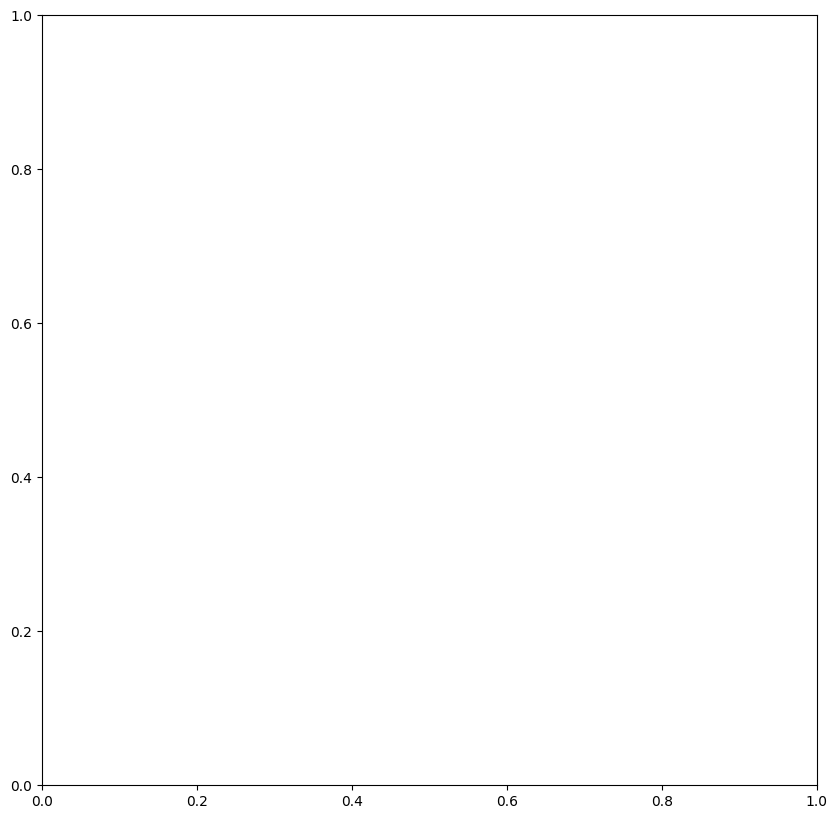

In [ ]:
#Single

#Plot and gather data
i=0


fig =plt.figure(figsize=(10, 10))

ax=fig.add_subplot(1,1,1)
temp_system=data[i]
res=50
target=.03
name, rep_beta_ra, rep_beta_dec, central_ra, central_dec, delta_log,sraar,sdecar=gridsearchV2(temp_system,res,target,1)

ax.scatter(rep_beta_ra, rep_beta_dec,color='black',marker='x')
sc=ax.scatter(sraar,sdecar,c=delta_log,cmap='rainbow_r',s=150)
ax.scatter(central_ra,central_dec,fc='none',ec='black',s=400)

plt.colorbar(sc,label='Average Differnce in Image Position (arcseconds)',ax=ax)
ax.title.set_text(name)
txt1="("+str(rep_beta_ra)+","+str(rep_beta_dec)+")"
txt2="("+str("%.3f" % central_ra)+","+str("%.3f" % central_dec)+")"
ax.annotate(txt1,(rep_beta_ra, rep_beta_dec))
ax.annotate(txt2,(central_ra,central_dec))
ax.grid()


In [ ]:
delta_reg=10**(delta_log)
min_delta_reg=min(delta_reg)
print(min_delta_reg)

0.009211350399772816


In [ ]:
#Single Systems
fname="RENAME2.pdf"
#Plot and gather data

f, axex = plt.subplots(1, 1, figsize=(10, 10), sharex=False, sharey=False)

numpix, deltapix, lensModel, kwargs_lens, beta_ra, beta_dec, label, name, delta_ra, delta_dec=systemmaker(data[i],central_ra,central_dec)
lens_plot.lens_model_plot(axex, numPix=numpix, deltaPix=deltapix, lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True, with_caustics=True, fast_caustic=False, coord_inverse=True)
plt.scatter(delta_ra,delta_dec,color="red")
#    for q, txt in enumerate(label):
#        ax.annotate(txt, (delta_ra[q], delta_dec[q]),color='white')
plt.scatter(beta_ra, beta_dec,color='red')
plt.title(name)
plt.grid()
plt.savefig(fname,format='pdf')
plt.close()